In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from keras.optimizers import Adam
from keras import backend as K


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import *
from keras import initializers
from keras.layers import BatchNormalization

In [ ]:


print("Start load train set")
# Load and preprocess training data
imgs_train = np.load('/content/drive/MyDrive/LUNA16/trainImages.npy').astype(np.float16)
imgs_mask_train = np.load('/content/drive/MyDrive/LUNA16/trainMasks.npy').astype(np.float16)
print("Finish load train set")


print("Start tranpose train set")
imgs_train = imgs_train.transpose(0, 2, 3, 1)
imgs_mask_train = imgs_mask_train.transpose(0, 2, 3, 1)
imgs_mask_train[imgs_mask_train > 0.] = 1.0
print("Finish tranpose load train set")



Start load train set
Finish load train set
Start tranpose train set
Finish tranpose load train set


In [ ]:
print("Train img shape : ",imgs_train.shape)
print("Train mask shape : ",imgs_mask_train.shape)


Train img shape :  (2590, 512, 512, 1)
Train mask shape :  (2590, 512, 512, 1)


In [ ]:



class_weights = {0: 0.9740012017916528, 1: 0.02599879820834716}
print("Class Weights:", class_weights)




Class Weights: {0: 0.9740012017916528, 1: 0.02599879820834716}


In [ ]:
from sklearn.model_selection import train_test_split
# Split the training data into training and validation sets
imgs_train, val_images, imgs_mask_train, val_masks = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=42)



In [ ]:
def data_generator(imgs, masks, batch_size=1):
    num_samples = len(imgs)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_imgs = imgs[indices]
        batch_masks = masks[indices]
        yield batch_imgs, batch_masks

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    smooth = 0.
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0

    # Flatten the true and predicted masks
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    dice_coeff_class_0 = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

    y_true_class_1 = 1 - y_true
    y_pred_class_1 = 1 - y_pred

    y_true_flat_class_1 = tf.keras.backend.flatten(y_true_class_1)
    y_pred_flat_class_1 = tf.keras.backend.flatten(y_pred_class_1)

    intersection_class_1 = tf.keras.backend.sum(y_true_flat_class_1 * y_pred_flat_class_1)
    dice_coeff_class_1 = (2.0 * intersection_class_1 + smooth) / (tf.keras.backend.sum(y_true_flat_class_1) + tf.keras.backend.sum(y_pred_flat_class_1) + smooth)

    # Calculate the mean of both Dice coefficients
    dice_coefficient = (dice_coeff_class_0 + dice_coeff_class_1) / 2.0
    return dice_coefficient

def weighted_dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)



In [ ]:
def weighted_binary_crossentropy(y_true, y_pred):
    weight_positive = 0.98  # Set a suitable weight for the positive class (you can experiment with different values)
    weight_negative = 0.02  # Set a suitable weight for the negative class (you can experiment with different values)

    # Calculate the binary cross-entropy loss
    bce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights to the loss based on the true labels
    weighted_bce = tf.where(K.equal(y_true, 1), weight_positive * bce, weight_negative * bce)

    return K.mean(weighted_bce)

In [ ]:

def get_unet_small():
    inputs = Input((512,512,1))
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu',padding='same', name='conv_1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(64, (3, 3), activation='elu',padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu',padding='same', name='conv_2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128, (3, 3), activation='elu',padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu',padding='same', name='conv_3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256, (3, 3), activation='elu',padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu',padding='same', name='conv_4')(conv4)
    conv4 = BatchNormalization()(conv4)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3],axis = 3)
    conv7 = Conv2D(128, (3, 3), activation='elu',padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='elu',padding='same', name='conv_7')(conv7)
    conv7 = BatchNormalization()(conv7)

    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2],axis = 3)
    conv8 = Conv2D(64, (3, 3), activation='elu',padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='elu',padding='same', name='conv_8')(conv8)
    conv8 = BatchNormalization()(conv8)

    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1],axis = 3)
    conv9 = Conv2D(32, (3, 3), activation='elu',padding='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='elu',padding='same', name='conv_9')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    # Compile the model with the custom loss function and optimizer




    return model


In [ ]:
# Renormalizing the masks
imgs_mask_train[imgs_mask_train > 0.] = 1.0


In [ ]:
model = get_unet_small()

In [ ]:

from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 100

print('Creating and compiling model...')

optimizer = Adam(learning_rate=0.00016815389884367667)
model.compile(optimizer=optimizer, loss=weighted_dice_coef_loss, metrics=['accuracy', dice_coefficient])

# Define model checkpoints
filepath = "/content/drive/MyDrive/LUNA16/U-netModel_hyperparameter_tuning_0.00016815389884367667.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_dice_coefficient', patience=6, verbose=1, mode='max', restore_best_weights=True)

print('Generate data...... ')
# Use a generator for training data to reduce memory usage
train_generator = data_generator(imgs_train, imgs_mask_train, batch_size=10)
steps_per_epoch = len(imgs_train) / 10
validation_data = (val_images, val_masks)

# Set mixed-precision policy if supported by GPU
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

print('Fitting model...')
# Train the model with early stopping
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_data, callbacks=[checkpoint, early_stopping])


Creating and compiling model...
Generate data...... 
Fitting model...
Epoch 1/100
208/207 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.7638 - dice_coefficient: 0.4997
Epoch 1: val_dice_coefficient improved from -inf to 0.07645, saving model to /content/drive/MyDrive/LUNA16/U-netModel_hyperparameter_tuning_0.00016815389884367667.hdf5
207/207 [==============================] - 303s 1s/step - loss: 0.8431 - accuracy: 0.7638 - dice_coefficient: 0.4997 - val_loss: 0.9489 - val_accuracy: 0.0774 - val_dice_coefficient: 0.0765
Epoch 2/100
208/207 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.9331 - dice_coefficient: 0.6298
Epoch 2: val_dice_coefficient improved from 0.07645 to 0.48777, saving model to /content/drive/MyDrive/LUNA16/U-netModel_hyperparameter_tuning_0.00016815389884367667.hdf5
207/207 [==============================] - 237s 1s/step - loss: 0.6888 - accuracy: 0.9331 - dice_coefficient: 0.6298 - val_loss: 0.8568 - val_accuracy: 0

Early stopping occurred at epoch 44


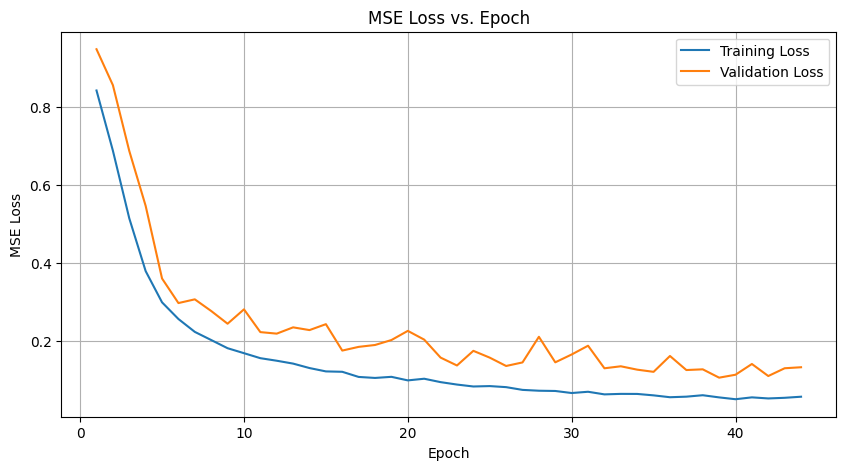

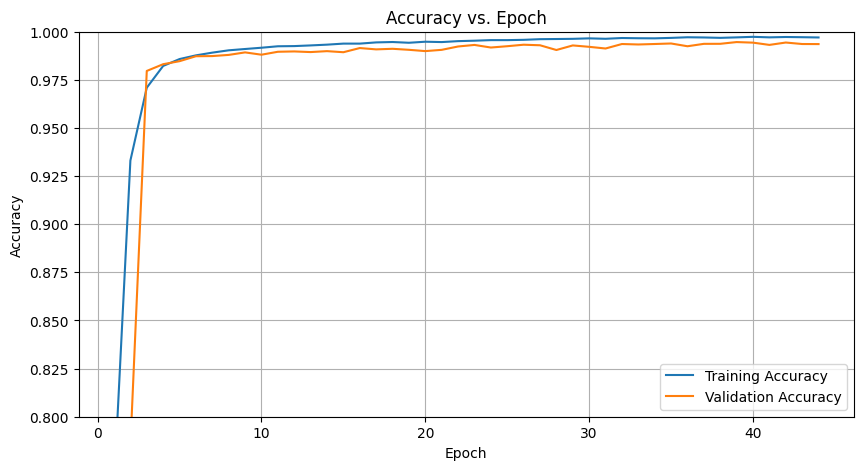

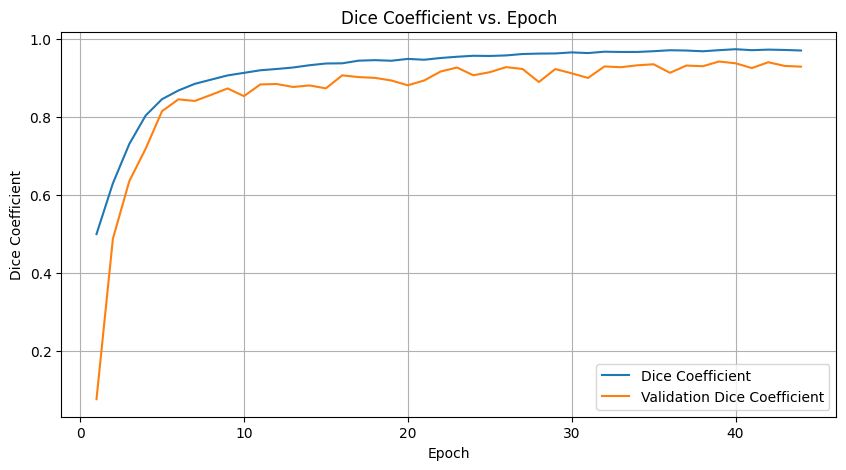

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object that contains training history
# Replace 'history' with the actual variable that stores your training history
history = model.history
# Get the epoch at which early stopping occurred
stopped_epoch = early_stopping.stopped_epoch
print(f"Early stopping occurred at epoch {stopped_epoch}")


# Extract loss and accuracy values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

# Create Line Graph for MSE Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, stopped_epoch + 1), train_loss[:stopped_epoch], label='Training Loss')
plt.plot(range(1, stopped_epoch + 1), val_loss[:stopped_epoch], label='Validation Loss')
plt.title('MSE Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Create Line Graph for Accuracy vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, stopped_epoch + 1), train_accuracy[:stopped_epoch], label='Training Accuracy')
plt.plot(range(1, stopped_epoch + 1), val_accuracy[:stopped_epoch], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.show()

# Create Line Graph for Dice Coefficient vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, stopped_epoch + 1), dice_coefficient[:stopped_epoch], label='Dice Coefficient')
plt.plot(range(1, stopped_epoch + 1), val_dice_coefficient[:stopped_epoch], label='Validation Dice Coefficient')
plt.title('Dice Coefficient vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()